In [4]:
from Model.Model import DNA_Channel_Model
from Model.config import DEFAULT_PASSER, TM_NGS, TM_NNP

from Encode.Helper_Functions import preprocess, rs_decode, dna_to_int_array, load_dna
from Encode.DNAFountain import DNAFountain, Glass
from Analysis.Analysis import inspect_distribution, save_simu_result, dna_chunk
from Analysis.Fountain_analyzer import error_profile,  FT_Analyzer

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gumbel_r, poisson

import numpy as np
import logging
logging.getLogger().setLevel(logging.CRITICAL)
# plt.rcParams['savefig.dpi'] = 300 
plt.rcParams['figure.dpi'] = 300

%load_ext autoreload
%autoreload 2

def hist(data,label = '', color = 'r'):
    sns.distplot(data, hist=False,bins = 10, color=color, kde_kws={"shade": True},label = label)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Distributions of read lines & loss + error

## 200 Repeats to determine the distribution prior

In [9]:
file_name = 'lena.jpg'
arg = DEFAULT_PASSER
arg.syn_depth = 15
arg.seq_depth = 5
arg.syn_sub_prob = 0.002
Model = DNA_Channel_Model(None,DEFAULT_PASSER)
FA = FT_Analyzer(file_name, Model, 0.3, 2)

for i in range(200):
    print(f'[{i+1}/200] experiment')
    FA.run()

Data split into 429 data chunks.
Encoding process done. Generated 558 strands after 3013 tries.
Alpha: 0.3, chunk_size: 20, rs_length: 2, information_density: 0.6993
[1/200] experiment
After reading 542 lines, 429 chunks are done. So far: 25 rejections (0.046125)
Success!
saved


/Users/lk/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


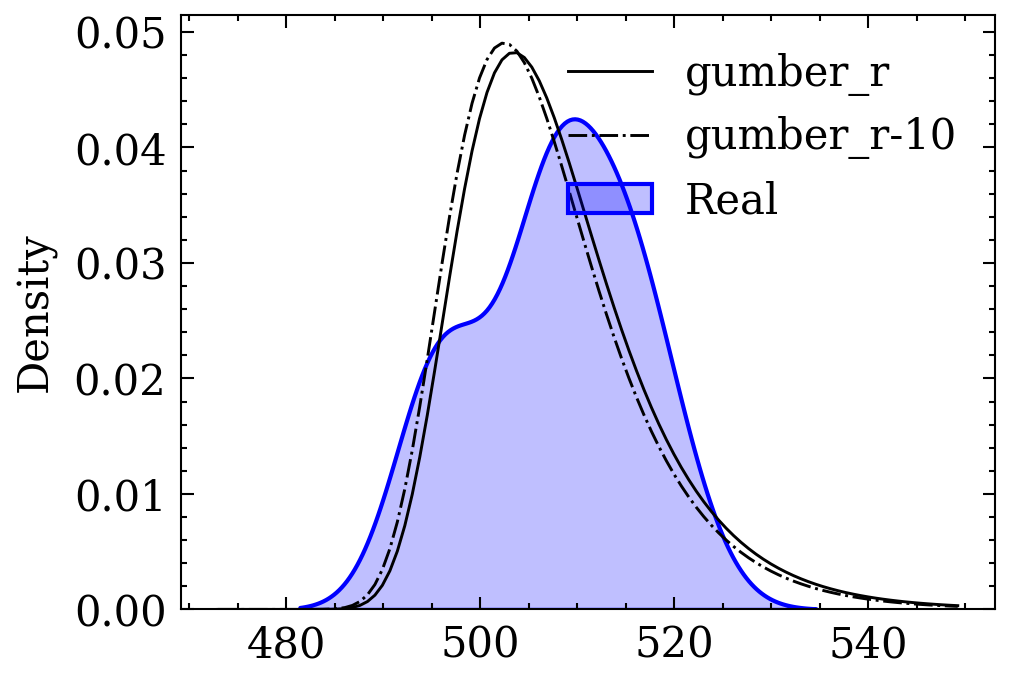

In [20]:
data = np.array(FA.decode_lines)

hist(data,'Real',color = 'blue')

loc, scale = gumbel_r.fit(data)
X = np.linspace(loc-4*scale, loc+6*scale, 100)

Y = gumbel_r.pdf(X, loc, scale)
plt.plot(X,Y,label = 'gumber_r',color = 'black', linestyle = '-',linewidth = 0.7)


loc, scale = gumbel_r.fit(data[:10])
Y = gumbel_r.pdf(X, loc, scale)
plt.plot(X,Y,label = 'gumber_r-10',color = 'black', linestyle = '-.',linewidth = 0.7)

# plt.xlabel('number of droplets for decoding')
# plt.ylabel('frequency')
# plt.tick_params(labelsize=9) 
plt.legend()

## Number Distribution of droplets for successful decoding

In [222]:
data = np.array(FA.decode_lines)
for dist in ['norm', 'expon', 'logistica', 'gumbel', 'gumbel_l', 'gumbel_r', 'extreme1']:
    print(scipy.stats.anderson(data, dist=dist))             

AndersonResult(statistic=1.4596980844447103, critical_values=array([0.565, 0.644, 0.772, 0.901, 1.071]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
AndersonResult(statistic=90.17716948333748, critical_values=array([0.919, 1.075, 1.337, 1.601, 1.951]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
AndersonResult(statistic=1.3065856273204588, critical_values=array([0.425, 0.562, 0.659, 0.768, 0.905, 1.009]), significance_level=array([25. , 10. ,  5. ,  2.5,  1. ,  0.5]))
AndersonResult(statistic=5.862819655567762, critical_values=array([0.467, 0.628, 0.746, 0.865, 1.024]), significance_level=array([25. , 10. ,  5. ,  2.5,  1. ]))
AndersonResult(statistic=5.862819655567762, critical_values=array([0.467, 0.628, 0.746, 0.865, 1.024]), significance_level=array([25. , 10. ,  5. ,  2.5,  1. ]))
AndersonResult(statistic=0.2966307486255175, critical_values=array([0.467, 0.628, 0.746, 0.865, 1.024]), significance_level=array([25. , 10. ,  5. ,  2.5,  1. ]))
AndersonResu

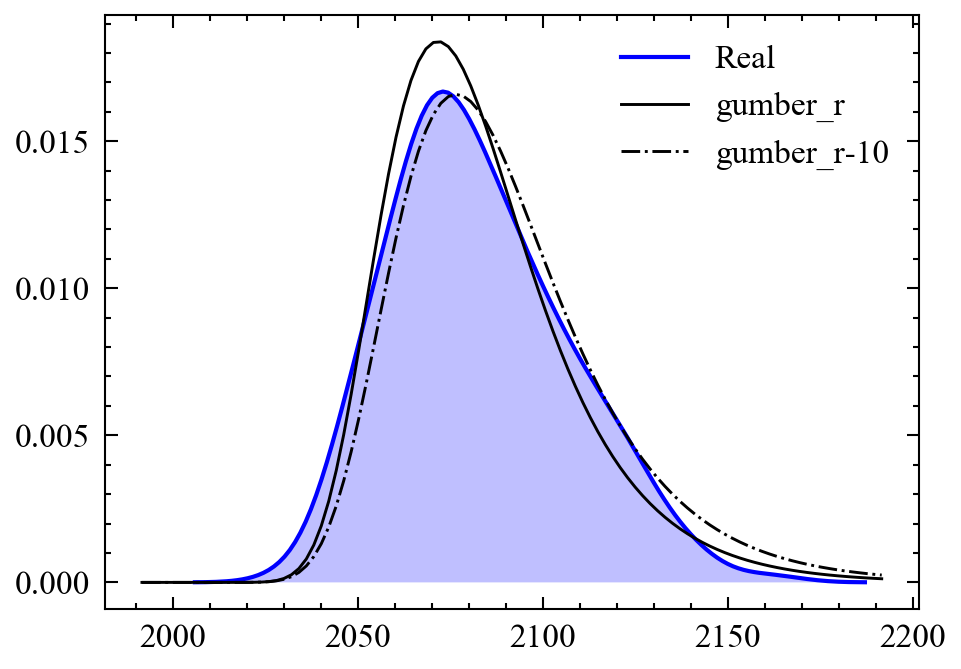

In [279]:
hist(data,'Real',color = 'blue')

loc, scale = gumbel_r.fit(data)
X = np.linspace(loc-4*scale, loc+6*scale, 100)

Y = gumbel_r.pdf(X, loc, scale)
plt.plot(X,Y,label = 'gumber_r',color = 'black', linestyle = '-',linewidth = 0.7)


loc, scale = gumbel_r.fit(data[:10])
Y = gumbel_r.pdf(X, loc, scale)
plt.plot(X,Y,label = 'gumber_r-10',color = 'black', linestyle = '-.',linewidth = 0.7)

# plt.xlabel('number of droplets for decoding')
# plt.ylabel('frequency')
# plt.tick_params(labelsize=9) 
plt.legend()

## Number Distribution of loss + fail

95.20398009950249
93.3076923076923


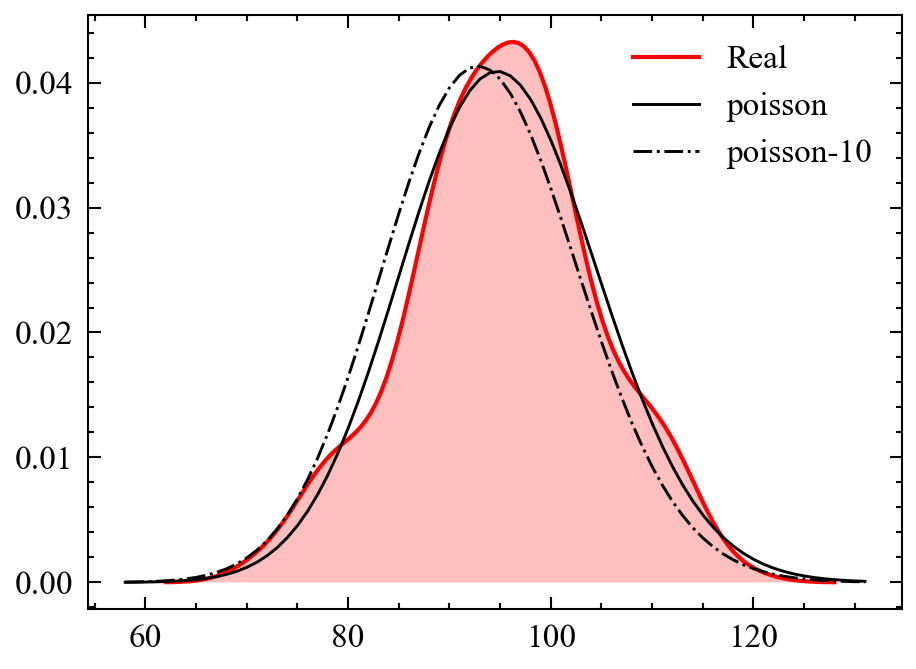

In [282]:
data = np.array(FA.fail_nums) 

hist(data,'Real')
u, sigma = np.mean(data), np.std(data)
X = np.arange(int(u-4*sigma),int(u+4*sigma))
print(u)

NY = poisson.pmf(X,u)
plt.plot(X,NY,label = 'poisson',color = 'black', linestyle = '-',linewidth = 0.7)

u, sigma = np.mean(data[0:13]), np.std(data[0:10])
print(u)
NY = poisson.pmf(X,u)
plt.plot(X,NY,label = 'poisson-10',color = 'black', linestyle = '-.',linewidth = 0.7)

plt.legend()

# Choose Proper Alpha and RS length

0.14538273413351274

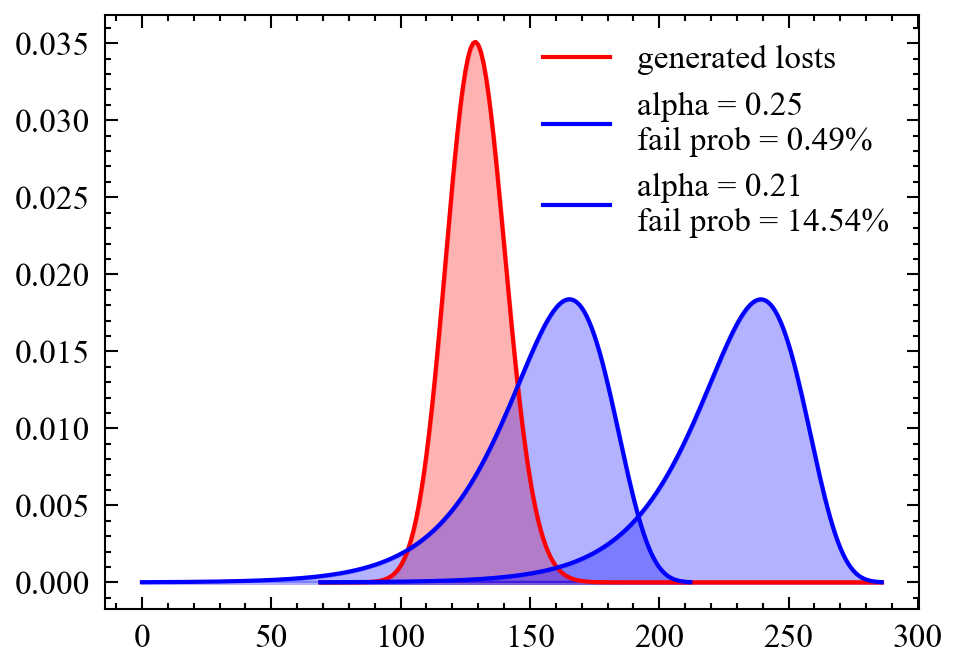

In [338]:
# FA.compute_overlap(0.2,True,True)
FA.fail_prob(0.25,True,True)
FA.fail_prob(0.21,True,False)
# FA.compute_overlap(0.3,True,False)

462(19.59%) with more than 1 errors


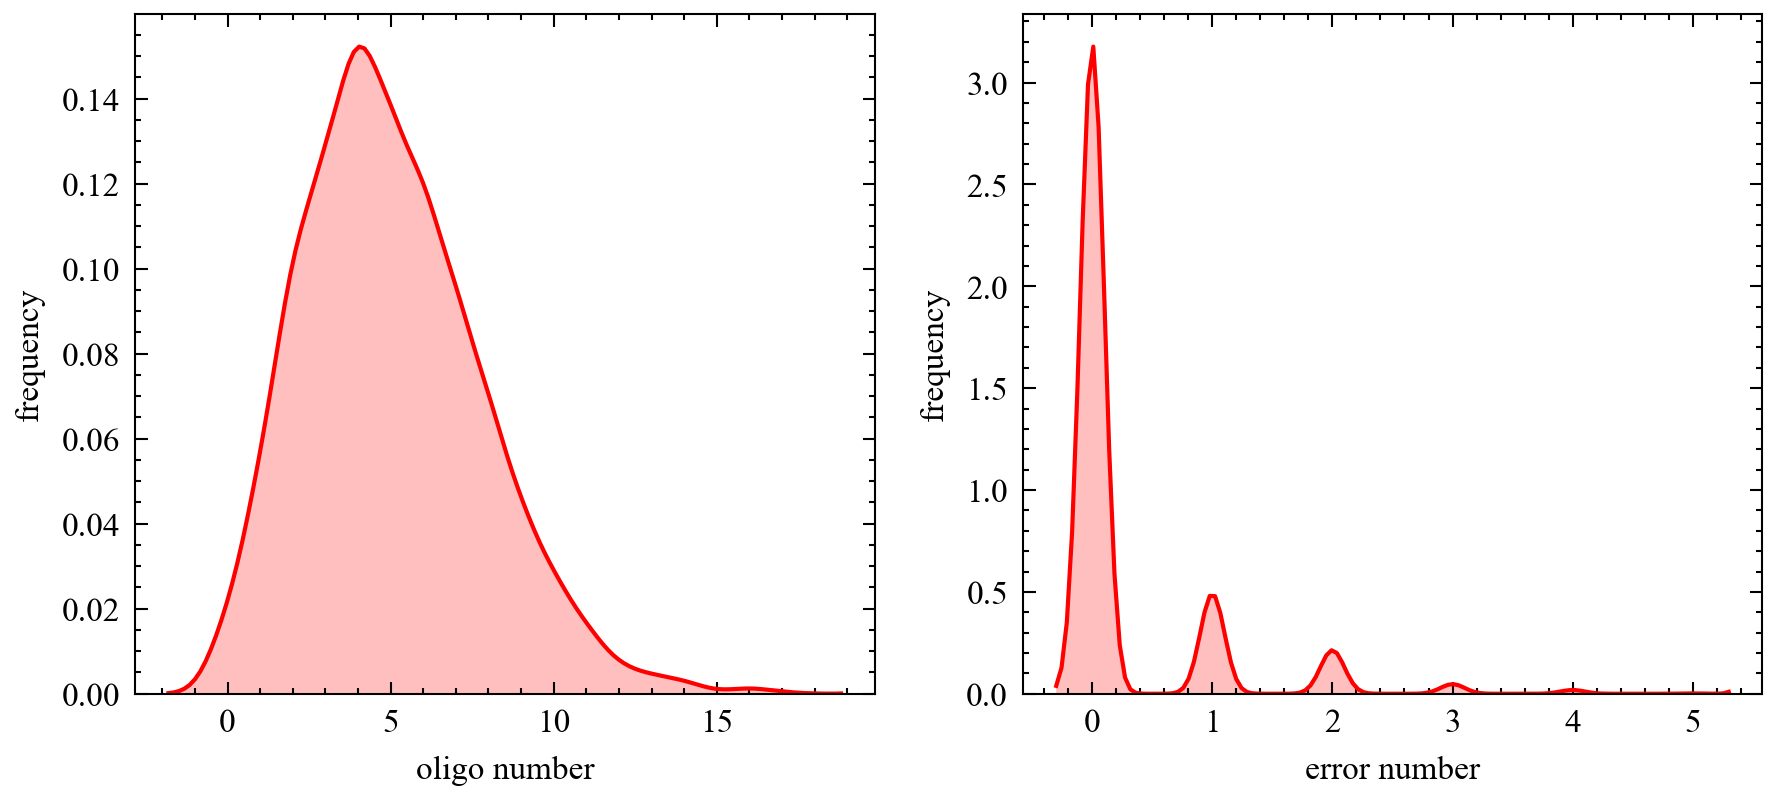

In [335]:
en = inspect_distribution(FA.out_dnas)

In [333]:
[sum([n == th for n in en]) for th in [1,2,3,4,5]]

[295, 127, 28, 11, 1]

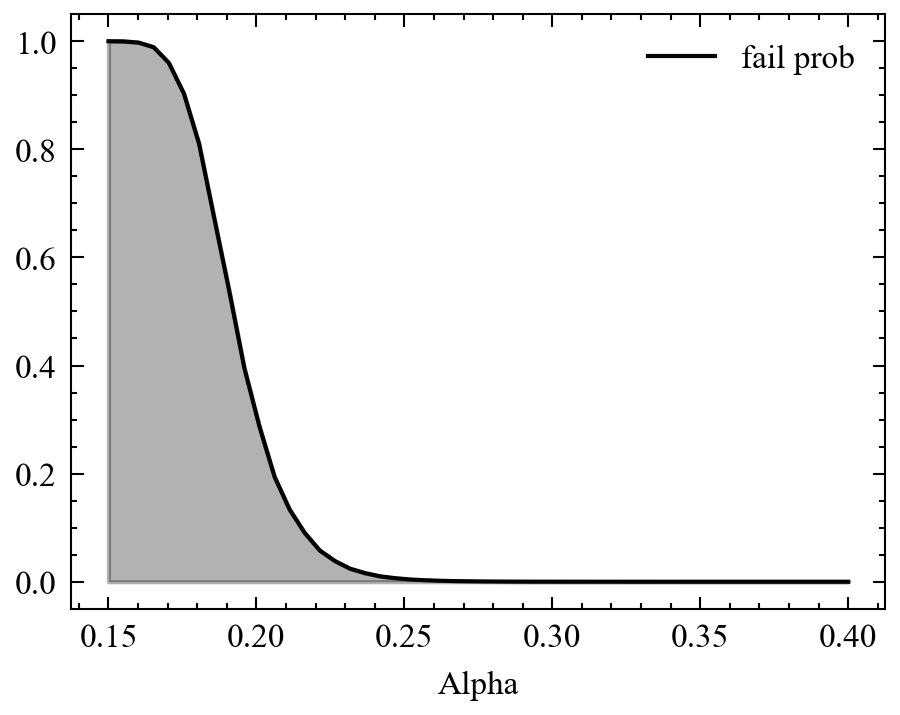

In [337]:
_ = FA.alpha_scan(points = 50, color = 'black')